# Multidimensional mekko or mosaic chart

Below is code I found on __[stack overflow](https://stackoverflow.com/questions/45352585/how-to-make-a-mosaic-plot-in-matplotlib)__ but it is limited to 3 categories and the last category can only have 1 or 2 values.  I'd like to do a recursive mekko like the R library vcd does (see __[here](http://www.sthda.com/english/articles/32-r-graphics-essentials/129-visualizing-multivariate-categorical-data/)__).  Notice how in that R package in the last link that the space between rectangles gets a little bit narrower in each iteration.  Another good example (2nd chart below) is in __[this pdf paper](https://cran.r-project.org/web/packages/vcd/vignettes/strucplot.pdf)__


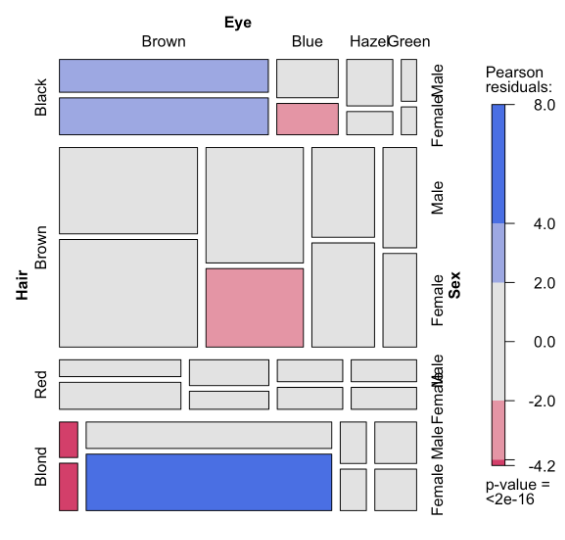

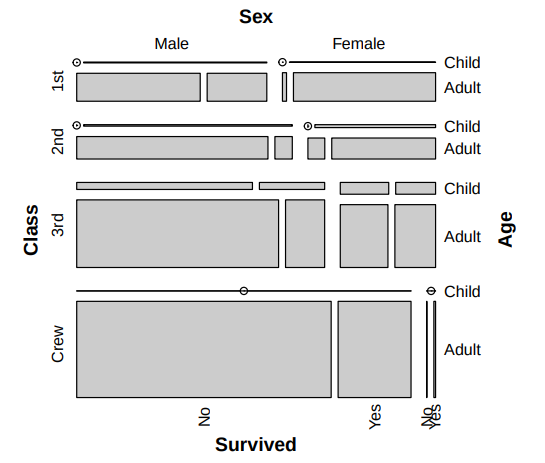

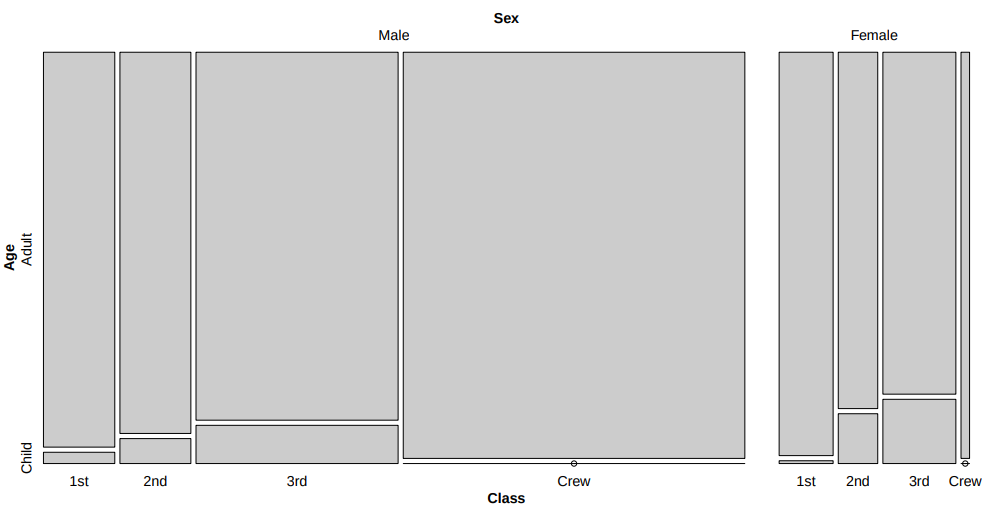

In [54]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [44]:
'''As nothing existed in python, here is the code I made. The last dimension should be of size 1 (i.e. a regular table) or 2 for now. Feel free to update the code to fix that, it might be unreadable with more than 3, though. It's a bit long but it does the job. Example below.

There are few options, most are self explanatory, otherwise:

dic_color_row: a dictionary where keys are the outer-most index (Index_1 in example below) and the values are colors, avoid black/gray colors
pad: the space between each bar of the plot
alpha_label: the 3rd dimension use alpha trick to differentiate, between them, it will be rendered as dark grey / light grey in the legend and you can change the name of each label (similar to col_labels or row_labels)
color_label: to add background color to the y-tick labels. [True/False]

'''



def mosaic_plot(df, dic_color_row, row_labels=None, col_labels=None, alpha_label=None, top_label="Size",
                x_label=None, y_label=None, pad=0.01, color_ylabel=False, ax=None, order="Size"):
    """ 

    From a contingency table NxM, plot a mosaic plot with the values inside. There should be a double-index for rows
    e.g.
                                         3   4   1   0   2  5
        Index_1          Index_2                       
        AA               C               0   0   0   2   3  0
                         P               6   0   0  13   0  0
        BB               C               0   2   0   0   0  0
                         P              45   1  10  10   1  0
        CC               C               0   6  35  15  29  0
                         P               1   1   0   2   0  0
        DD               C               0  56   0   3   0  0
                         P              30   4   2   0   1  9

    order: how columns are order, by default, from the biggest to the smallest in term of category. Possible values are 
        - "Size" [default]
        - "Normal" : as the columns are order in the input df
        - list of column names to reorder the column
    top_label: Size of each columns. The label can be changed to adapt to your value. 
               If `False`, nothing is displayed and the secondary legend is set on top instead of on right.  
    """

    is_multi = len(df.index.names) == 2
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(len(df.columns), len(df.index.get_level_values(0).unique())))

    size_col = df.sum().sort_values(ascending=False)
    prop_com = size_col.div(size_col.sum())

    if order == "Size":
        df = df[size_col.index.values]
    elif order == "Normal":
        prop_com = prop_com[df.columns]
        size_col = size_col[df.columns]
    else:
        df = df[order]
        prop_com = prop_com[order]
        size_col = size_col[order]

    if is_multi:
        inner_index = df.index.get_level_values(1).unique()
        prop_ii0 = (df.swaplevel().loc[inner_index[0]]/(df.swaplevel().loc[inner_index[0]]+df.swaplevel().loc[inner_index[1]])).fillna(0)
        alpha_ii = 0.5
        true_y_labels = df.index.levels[0]
    else:
        alpha_ii = 1
        true_y_labels = df.index

    Yt = (df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())+pad).cumsum() - pad
    Ytt = df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())

    x = 0    
    for j in df.groupby(level=0).sum().iteritems():
        bot = 0
        S = float(j[1].sum())
        for lab, k in j[1].iteritems():
            bars = []
            ax.bar(x, k/S, width=prop_com[j[0]], bottom=bot, color=dic_color_row[lab], alpha=alpha_ii, lw=0, align="edge")
            if is_multi:
                ax.bar(x, k/S, width=prop_com[j[0]]*prop_ii0.loc[lab, j[0]], bottom=bot, color=dic_color_row[lab], lw=0, alpha=1, align="edge")
            bot += k/S + pad
        x += prop_com[j[0]] + pad

    ## Aesthetic of the plot and ticks
    # Y-axis
    if row_labels == None:
        row_labels = Yt.index
    ax.set_yticks(Yt - Ytt/2)
    ax.set_yticklabels(row_labels)

    ax.set_ylim(0, 1 + (len(j[1]) - 1) * pad)
    if y_label == None:
        y_label = df.index.names[0]
    ax.set_ylabel(y_label)

    # X-axis
    if col_labels == None:
        col_labels = prop_com.index
    xticks = (prop_com + pad).cumsum() - pad - prop_com/2.
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_labels)
    ax.set_xlim(0, prop_com.sum() + pad * (len(prop_com)-1))

    if x_label == None:
        x_label = df.columns.name
    ax.set_xlabel(x_label)

    # Top label
    if top_label:
        ax2 = ax.twiny()
        ax2.set_xlim(*ax.get_xlim())
        ax2.set_xticks(xticks) 
        ax2.set_xticklabels(size_col.values.astype(int))
        ax2.set_xlabel(top_label)
        ax2.tick_params(top=False, right=False, pad=0, length=0)

    # Ticks and axis settings

    ax.tick_params(top=False, right=False, pad=5)
    sns.despine(left=0, bottom=False, right=0, top=0, offset=3)

    # Legend
    if is_multi: 
        if alpha_label == None:
            alpha_label = inner_index
        bars = [ax.bar(np.nan, np.nan, color="0.2", alpha=[1, 0.5][b]) for b in range(2)]
        if top_label:
            plt.legend(bars, alpha_label, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, )
        else:
            plt.legend(bars, alpha_label, loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)
    plt.tight_layout(rect=[0, 0, .9, 0.95])
    if color_ylabel:
        for tick, label in zip(ax.get_yticklabels(), true_y_labels):
            tick.set_bbox(dict( pad=5, facecolor=dic_color_row[label]))
            tick.set_color("w")
            tick.set_fontweight("bold")

    return ax

In [45]:
df = pd.read_csv("Downloads/titanic_clean.csv")
df

,name,gender,age,class,embarked,country,fare,survived
0,"Abbing, Mr. Anthony",male,42.0,3rd,Southampton,United States,7.1100,no
1,"Abbott, Mr. Eugene Joseph",male,13.0,3rd,Southampton,United States,20.0500,no
2,"Abbott, Mr. Rossmore Edward",male,16.0,3rd,Southampton,United States,20.0500,no
3,"Abbott, Mrs. Rhoda Mary 'Rosa'",female,39.0,3rd,Southampton,England,20.0500,yes
4,"Abelseth, Miss. Karen Marie",female,16.0,3rd,Southampton,Norway,7.1300,yes
...,...,...,...,...,...,...,...,...
1208,"Yvois, Miss. Henriette",female,24.0,2nd,Southampton,France,13.0000,no
1209,"Zakarian, Mr. Mapriededer",male,22.0,3rd,Cherbourg,Turkey,7.0406,no
1210,"Zakarian, Mr. Ortin",male,27.0,3rd,Cherbourg,Turkey,7.0406,no
1211,"Zenni, Mr. Philip",male,25.0,3rd,Cherbourg,Lebanon,7.0406,yes


In [52]:
data = pd.crosstab([df['gender'], df['class']], df['survived'])
data

survived       no  yes
gender class          
female 1st      5  127
       2nd     11   91
       3rd    104  103
male   1st    109   60
       2nd    137   24
       3rd    377   65

/tmp/ipykernel_92175/637842798.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout(rect=[0, 0, .9, 0.95])


<AxesSubplot:xlabel='survived', ylabel='gender'>

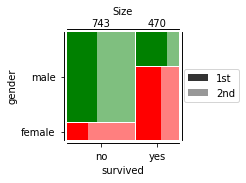

In [53]:
colors = {'male': 'green', 'female': 'red'}
mosaic_plot(data, colors)

In [22]:
# Counts of each unique value in the 'survived' column.
df['survived'].value_counts()

no     743
yes    470
Name: survived, dtype: int64

In [23]:
# Proportions of each unique value in the 'survived' column.
df['survived'].value_counts(normalize=True)

no     0.612531
yes    0.387469
Name: survived, dtype: float64

In [24]:
# Cross-tabulation of counts for 'gender' (rows) by 'survived' (columns).
pd.crosstab(df['gender'], df['survived'])

survived,no,yes
gender,,
female,120,321
male,623,149


In [25]:
# Cross-tabulation of proportions for 'gender' (rows) by 'survived' (columns).
# Proportions are over the row.
pd.crosstab(df['gender'], df['survived'], normalize='index')

survived,no,yes
gender,,
female,0.272109,0.727891
male,0.806995,0.193005


In [26]:
# Cross-tabulation of proportions for 'gender' (rows) by 'survived' (columns).
# Proportions are over the column.
pd.crosstab(df['gender'], df['survived'], normalize='columns')

survived,no,yes
gender,,
female,0.161507,0.682979
male,0.838493,0.317021


In [27]:
mwc = df['gender'].copy()  # Copy-right!
mwc[df['age'] <= 16] = 'child'
pd.crosstab(mwc, df['survived'], normalize='index')

survived,no,yes
gender,,
child,0.467153,0.532847
female,0.257979,0.742021
male,0.831429,0.168571


In [28]:
# Counts for passengers who survived, broken down by class and male, female,
# child.
categories = [df['class'], mwc]
pd.crosstab(categories, df['survived'])

survived       no  yes
class gender          
1st   child     1    8
      female    4  124
      male    109   55
2nd   child     1   25
      female   11   77
      male    136   13
3rd   child    62   40
      female   82   78
      male    337   50

In [29]:
# Proportions surviving in sub-categories of class, male/female/child.
pd.crosstab(categories, df['survived'], normalize='index')

survived            no       yes
class gender                    
1st   child   0.111111  0.888889
      female  0.031250  0.968750
      male    0.664634  0.335366
2nd   child   0.038462  0.961538
      female  0.125000  0.875000
      male    0.912752  0.087248
3rd   child   0.607843  0.392157
      female  0.512500  0.487500
      male    0.870801  0.129199

In [30]:
# Proportions surviving in sub-categories of class, male/female/child,
# with 'survived' in the rows, and the subcategories in the columns.
pd.crosstab(df['survived'], categories, normalize='columns')

class          1st                          2nd                        3rd  \
gender       child   female      male     child female      male     child   
survived                                                                     
no        0.111111  0.03125  0.664634  0.038462  0.125  0.912752  0.607843   
yes       0.888889  0.96875  0.335366  0.961538  0.875  0.087248  0.392157   

class                       
gender    female      male  
survived                    
no        0.5125  0.870801  
yes       0.4875  0.129199